<div align="center">
    <h1>Υπολογιστική Γεωμετρία (1η Εργασία)</h1>
</div>

### Ορισμός Σημείου (Point Definition)
Θα ξεκινήσουμε την υλοποίησή μας ορίζοντας τη **γενική κλάση** που θα αναπαριστά ένα **σημείο** στο $\mathbb{R}^2$ με συντεταγμένες $x$ και $y$.

In [60]:
class Vector2D:
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y

    def __repr__(self):
        return f"({self.x:.3f}, {self.y:.3f})"


### Ορισμός Κυρτού Περιβλήματος (Convex Hull Definition)
Θα συνεχίσουμε ορίζοντας τη **κλάση** η οποία θα αναπαριστά ένα **κυρτό περίβλημα**, το οποίο θα αποτελείται από **σημεία** στον $\mathbb{R}^2$ χώρο, καθώς και **ακμές** οι οποίες θα υποδηλώνουν τις άκρες του περιβλήματος.

In [61]:
import numpy as np
from matplotlib import pyplot as plt

class Convex_Hull:
  def __init__(self, points: np.ndarray[Vector2D], hull_points: np.ndarray[Vector2D]):
    self.points = points
    self.hull_points = hull_points
    self.edges = self.__construct_edges(hull_points)

  def __construct_edges(self, hull_points: np.ndarray[Vector2D]):
    """ Constructs the edges list of the convex hull. """
    edges = []

    for i in range(len(hull_points) - 1):
        edges.append((hull_points[i], hull_points[i + 1]))
    edges.append((hull_points[-1], hull_points[0]))

    return edges

  def __repr__(self):
    return f"Convex_Hull\n-points={self.points}\n-edges={self.edges}"
  
  def plot(self, axes: plt.axes = None, title: str = ""):
    """
    Plots the convex hull. This function will plot the points and edges of the convex hull.
    """
    if axes is not None:
      axes.scatter([point.x for point in self.points], [point.y for point in self.points], color='#339AFF', s=10)

      # Plot the edges of the convex hull
      for edge in self.edges:
        axes.plot([edge[0].x, edge[1].x], [edge[0].y, edge[1].y], color='#FF7070')

      axes.axis('off')
      axes.set_title(title)
    else:
      plt.scatter([point.x for point in self.points], [point.y for point in self.points], color='#339AFF', s=10)

      # Plot the edges of the convex hull
      for edge in self.edges:
        plt.plot([edge[0].x, edge[1].x], [edge[0].y, edge[1].y], color='#FF7070')

      plt.axis('off')
      plt.title(title)
      plt.show()

### Ορισμός Γενικής Έννοιας του Αλγορίθμου Εύρεσης ΚΠ2
Στη συνέχεια θα ορίσουμε τη **γενική αφηρημένη κλάση** (abstract) του αλγορίθμου **εύρεσης** ενός **κυρτού περιβλήματος**. Κάθε αλγόριθμος που θα υλοποιήσουμε στη συνέχεια θα **κληρονομεί** αυτή την κλάση και δωσμένου ενός συνόλου από σημεία, θα υλοποιεί τη δικιά του μέθοδο εύρεσης του κυρτού περιβλήματος.

In [62]:
import numpy as np
from abc import ABC, abstractmethod


class ConvexHullSolutionAlgorithm(ABC):

  @abstractmethod
  def __call__(self, points: np.ndarray[Vector2D]) -> np.ndarray[Vector2D]:
    ...


### Ορισμός Αυξητικού Αλγορίθμου (Graham's Scan Algorithm)
Θα ξεκινήσουμε ορίζοντας τον πρώτο μας αλγόριθμο, ο οποίος είναι ο **Ααυξητικός Αλγόριθμος** (Graham's Scan Algorithm). Ο αλγόριθμος αναπαριστάται με μία κλάση όπως φαίνεται παρακάτω όπου μπορεί κάποιος να τον καλέσει χρησιμοποιώντας τη μέθοδο `__call__()`.

In [63]:
import numpy as np

class GrahamScanAlgorithm(ConvexHullSolutionAlgorithm):

  def __is_right_turn(self, p1: Vector2D, p2: Vector2D, p3: Vector2D) -> bool:
    # Define the supporting matrix for the three points to determine the orientation of the points
    matrix: np.ndarray[np.ndarray[float]] = np.array([
      [1, p1.x, p1.y], 
      [1, p2.x, p2.y], 
      [1, p3.x, p3.y]
    ])
    return np.linalg.det(matrix) < 0
  
  def __construct_upper_hull(self, points: np.ndarray[Vector2D]) -> np.ndarray[Vector2D]:
    L_upper: np.ndarray[Vector2D] = [points[0], points[1]]

    # Construct the upper hull of the convex hull
    for i in range(2, len(points)):
      L_upper.append(points[i])
      while len(L_upper) > 2 and not self.__is_right_turn(L_upper[-3], L_upper[-2], L_upper[-1]):
        L_upper.pop(-2)

    return L_upper
  
  def __construct_lower_hull(self, points: np.ndarray[Vector2D]) -> np.ndarray[Vector2D]:
    L_lower: np.ndarray[Vector2D] = [points[-1], points[-2]]

    # Construct the lower hull of the convex hull
    for i in range(len(points) - 3, -1, -1):
      L_lower.append(points[i])
      while len(L_lower) > 2 and not self.__is_right_turn(L_lower[-3], L_lower[-2], L_lower[-1]):
        L_lower.pop(-2)

    # Remove the first and last points from L_lower to avoid duplication
    L_lower.pop(0)
    L_lower.pop(-1)

    return L_lower

  def __call__(self, points: np.ndarray[Vector2D]) -> np.ndarray[Vector2D]:
    # Sort the points by their x-coordinate, then by their y-coordinate, and insert p1 and p2 to the L_upper set
    points: np.ndarray[Vector2D] = sorted(points, key=lambda p: (p.x, p.y))
    
    # Construct the upper and lower hulls of the convex hull
    L_upper: np.ndarray[Vector2D] = self.__construct_upper_hull(points)
    L_lower: np.ndarray[Vector2D] = self.__construct_lower_hull(points)

    # Merge the L_upper and L_lower sets to form the convex hull and return the result
    L: np.ndarray[Vector2D] = L_upper + L_lower

    return L

### Δοκιμή Αλγορίθμου
Ας δοκιμάσουμε τον αλγόριθμό. Για αρχή θα αρχικοποιήσουμε ένα σύνολο με **100 τυχαία** σημεία στο $\mathbb{R}^2$ χώρο. θα δημιουργήσουμε **δύο** σύνολα δεδομένων. Το ένα σύνολο θα περιέχει τυχαία δεδομένα όπου το χωρίο που θα καταλαμβάνουν θα έχει **ορθογωνιακό** σχήμα, και το δεύτερο σύνολο θα περιέχει δεδομένα τα οποία θα **καταλαμβάνουν** κυκλικό σχήμα.

In [64]:
import numpy as np

POINTS_COUNT = 100

# Generate the rectangle set containing the random points
rectangle_points_set: np.ndarray[Vector2D] = []
for i in range(POINTS_COUNT):
  random_point = Vector2D(x=np.random.sample(), y=np.random.sample())
  rectangle_points_set.append(random_point)

# Generate the circular set containing the random points
circular_points_set: np.ndarray[Vector2D] = []
for i in range(POINTS_COUNT):
  angle = np.random.uniform(0, 2 * np.pi)
  radius = np.random.uniform(0, 1)
  x, y = radius * np.cos(angle), radius * np.sin(angle)
  random_point = Vector2D(x, y)
  circular_points_set.append(Vector2D(x, y))


Ας οπτικοποιήσουμε αυτά τα σύνολα δεδομένων.

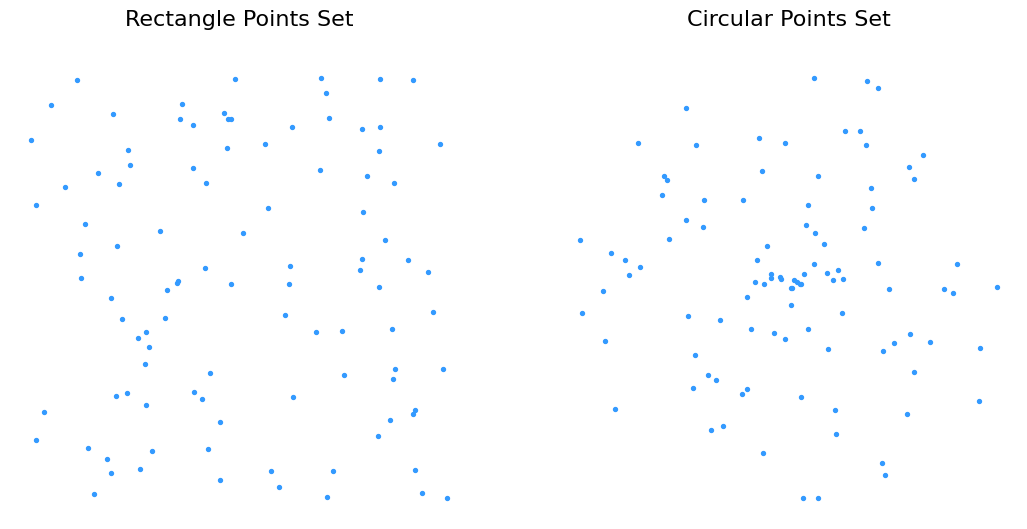

In [65]:
figure, axes = plt.subplots(1, 2, figsize=(13, 6))
figure.patch.set_alpha(0)

for s_point, c_point in zip(rectangle_points_set, circular_points_set):
  axes[0].scatter(s_point.x, s_point.y, color='#339AFF', s=8)
  axes[1].scatter(c_point.x, c_point.y, color='#339AFF', s=8)

axes[0].set_title('Rectangle Points Set\n', fontsize=16)
axes[0].axis('off')
axes[0].patch.set_alpha(0)
axes[1].set_title('Circular Points Set\n', fontsize=16)
axes[1].axis('off')
axes[1].patch.set_alpha(0)

plt.show()

### Εύρεση του κυρτού περιβλήματος (Convex Hull Calculation)
Έχοντας δημιουργήσει τα σύνολα δεδομένων μας, ήρθε η ώρα να δοκιμάσουμε τον αλγόριθμό μας.

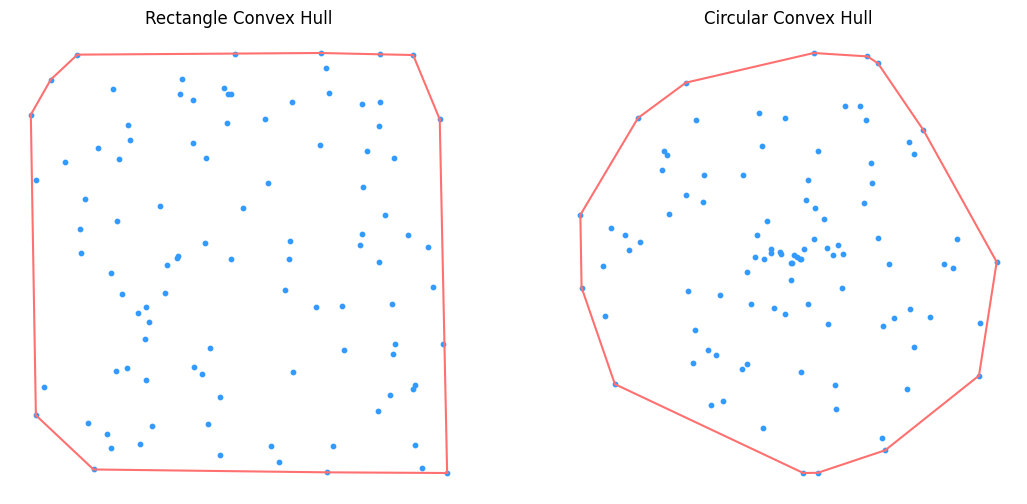

In [66]:
# Initialize the algorithm
gs_algorithm = GrahamScanAlgorithm()

# Compute the convex hull for the rectangle and the circular points set
rect_gs_result = gs_algorithm(np.array(rectangle_points_set))
circ_gs_result = gs_algorithm(np.array(circular_points_set))

# Create the convex hull objects
rect_convex_hull = Convex_Hull(rectangle_points_set, rect_gs_result)
circ_convex_hull = Convex_Hull(circular_points_set, circ_gs_result)

# Plot the convex hulls
figure, axes = plt.subplots(1, 2, figsize=(13, 6))
rect_convex_hull.plot(axes[0], title="Rectangle Convex Hull")
circ_convex_hull.plot(axes[1], title="Circular Convex Hull")

Όπως παρατηρούμε από τα παραπάνω διαγράμματα, ο αλγόριθμός μας λειτούργησε αποτελεσματικά για τα δύο σύνολα δεδομένων.

### Αλγόριθμος Περιτυλίγματος (Gift Wrapping)
Θα συνεχίσουμε υλοποιώντας τους υπόλοιπους αλγορίθμους, ξεκινώντας με τον **Αλγόριθμο Του Περιτυλίγματος** (Gift Wrapping Algorithm)

In [67]:
class GiftWrappingAlgorithm(ConvexHullSolutionAlgorithm):
  def __is_right_turn(self, p1: Vector2D, p2: Vector2D, p3: Vector2D) -> bool:
    # Define the supporting matrix for the three points to determine the orientation of the points
    matrix: np.ndarray[np.ndarray[float]] = np.array([
      [1, p1.x, p1.y], 
      [1, p2.x, p2.y], 
      [1, p3.x, p3.y]
    ])
    return np.linalg.det(matrix) < 0
  
  def __call__(self, points: np.ndarray[Vector2D]) -> np.ndarray[Vector2D]:
    S = points.copy()
    # Find the leftmost point
    r0 = min(S, key=lambda p: (p.x, p.y))
    r = r0
    
    selected_points: np.ndarray[Vector2D] = [r]
    
    while True:
      # Let u be a point on the convex hull that has not been selected yet
      remaining_points: np.ndarray[Vector2D] = [p for p in S if p not in selected_points]
      u = remaining_points[0]

      for t in points:
        if self.__is_right_turn(r, u, t): # TODO: And if the points are on the same line and u is between r and t
          u = t
      
      if u == r0:
        return selected_points
      else:
        r = u
        S.remove(r)
        selected_points.append(r)


In [68]:
gw_algorithm = GiftWrappingAlgorithm()
hull = gw_algorithm(circular_points_set)

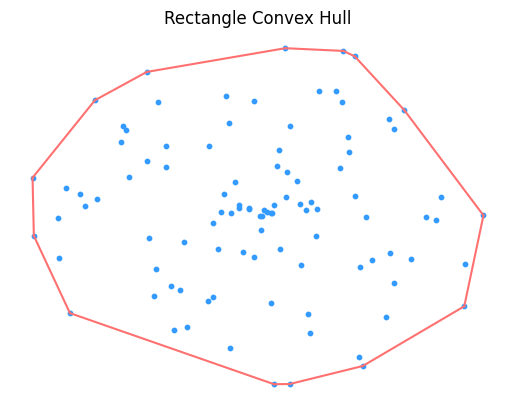

In [69]:
convex_hull = Convex_Hull(circular_points_set, hull)
convex_hull.plot(title="Rectangle Convex Hull")